In [1]:
import os
import sys
sys.path.append('../../cnn_design-space/cnnbench/')
sys.path.append('../../boshnas/boshnas/')
sys.path.append('../')

import argparse
import numpy as np
import yaml
import random
import tabulate
import subprocess
import time
import json
import hashlib
import random

import torch

from six.moves import cPickle as pickle
from tqdm import tqdm

from boshnas_2inp import BOSHNAS as BOSHCODE
from acq import gosh_acq as acq

from run_boshcode import convert_to_tabular, update_dataset, get_neighbor_hash

from matplotlib import pyplot as plt

from library import GraphLib, Graph
from utils import print_util as pu

In [2]:
# Define paths
graphlib_file = '../../cnn_design-space/cnnbench/dataset/dataset_mini.json'
new_graphlib_file = './dataset_mini_trained.json'
accel_embeddings_file = '../../accelerator_design-space/accelbench/embeddings/embeddings.pkl'
cnn_config_file = '../../cnn_design-space/cnnbench/configs/CIFAR10/config.yaml'
models_dir = '../../models'
accel_dataset_file = '../accel_dataset/accel_dataset_mini_bkp.pkl'
accel_dataset_file_trained = './accel_dataset_mini_trained.pkl'
performance_weights = [0, 0.2, 0, 0.2, 0.1, 0.2, 0.3]

In [2]:
graphLib = GraphLib.load_from_dataset(graphlib_file)

# accel_embeddings = pickle.load(open(accel_embeddings_file, 'rb'))
# accel_embeddings = np.array(accel_embeddings)

cnn_config = yaml.safe_load(open(cnn_config_file))

cnn_models_dir = os.path.join(models_dir, 'cnnbench_models', cnn_config['dataset'])
accel_models_dir = os.path.join(models_dir, 'accelbench_models')

# Get trained CNN models and Accelerator architectures
trained_cnn_hashes = os.listdir(cnn_models_dir)
trained_cnn_hashes_new = []
for cnn_hash in trained_cnn_hashes:
    if 'model.pt' in os.listdir(os.path.join(cnn_models_dir, cnn_hash)): trained_cnn_hashes_new.append(cnn_hash)
        
trained_cnn_hashes = trained_cnn_hashes_new
trained_accel_hashes = [accel_hash[:-4] for accel_hash in os.listdir(accel_models_dir)]

# Load CNN-Accelerator pairs dataset
accel_dataset = pickle.load(open(accel_dataset_file, 'rb'))

accel_embeddings = [accel['accel_emb'].tolist() for accel in accel_dataset.values()]
accel_embeddings = [str(elem) for elem in accel_embeddings]
accel_embeddings = [eval(elem) for elem in set(accel_embeddings)]
accel_embeddings = np.array(accel_embeddings)

accel_hashes = list(accel_dataset.keys())

# Check trained_accel_hashes have all respective CNNs trained
trained_accel_hashes_new = []
for accel_hash in trained_accel_hashes:
    if accel_hash not in accel_hashes:
        print(f'Trained CNN-Accelerator pair with hash: {accel_hash}, not in current dataset')
        continue
    cnn_hash = accel_dataset[accel_hash]['cnn_hash']
    if cnn_hash not in trained_cnn_hashes:
        print(f'CNN-Accelerator pair with hash: {accel_hash}, doesn\'t have respective CNN trained (with hash: {cnn_hash})')
    else:
        trained_accel_hashes_new.append(accel_hash)
        
trained_accel_hashes = trained_accel_hashes_new

old_best_performance = update_dataset(graphLib, accel_dataset, cnn_models_dir, accel_models_dir, 
    new_graphlib_file, accel_dataset_file_trained, performance_weights, save_dataset=False)

# Get entire dataset in embedding space
cnn_embeddings = []
for graph in graphLib.library:
    cnn_embeddings.append(graph.embedding)
cnn_embeddings = np.array(cnn_embeddings)

min_cnn, max_cnn = np.min(cnn_embeddings, axis=0), np.max(cnn_embeddings, axis=0)
min_accel, max_accel = np.min(accel_embeddings, axis=0), np.max(accel_embeddings, axis=0)

X_ds = []
for cnn_idx in range(cnn_embeddings.shape[0]):
    for accel_idx in range(accel_embeddings.shape[0]):
        X_ds.append((cnn_embeddings[cnn_idx, :], accel_embeddings[accel_idx, :]))
        
# Initialize the two-input BOSHNAS model
surrogate_model = BOSHCODE(input_dim1=cnn_embeddings.shape[1],
                          input_dim2=accel_embeddings.shape[1],
                          bounds1=(min_cnn, max_cnn),
                          bounds2=(min_accel, max_accel),
                          trust_region=False,
                          second_order=True,
                          parallel=True,
                          model_aleatoric=True,
                          save_path='./surrogate_model/',
                          pretrained=False)

# Get initial dataset after finetuning num_init models
X_cnn, X_accel, y = convert_to_tabular(accel_dataset, graphLib, performance_weights)
max_loss = np.amax(y)

Trained CNN-Accelerator pair with hash: 293181b319b0deec6cfc31771b3c1464fe538f6f93d9eb22b2d73891d50e11fc, not in current dataset
CNN-Accelerator pair with hash: d26935273a41e425dbef42f8a61ab57b4fba8483eababe4f044625410030f63a, doesn't have respective CNN trained (with hash: d74c8175e990c815efa1092f254fc65cef658f5051e36b404777a3b3bc31e059)
CNN-Accelerator pair with hash: af95420c27b1e19b0a1fb8d1166fb646c8308cf89a34647765c71a9463db85b6, doesn't have respective CNN trained (with hash: a3c500d1cd395f12812fae0db02e72ff3ec9962a0c0e372dc812541f7ba038a2)
CNN-Accelerator pair with hash: 95bd07e8360817122001ccb7bb73bb58d82c4bc50560d7ea877ccceede95b1d2, doesn't have respective CNN trained (with hash: d6b07ee2297fa76ab5e71507ca95ab73f9e6e95461cb856ac79b34818751aba8)
CNN-Accelerator pair with hash: e883fa4f8988b3f67bd9e26ae334edb44d031a90851d22bb0566d64b0ac6cbec, doesn't have respective CNN trained (with hash: 1abf976cd9b816f2e37532b7cb82dba8732ffea628880c3a716b6f5d5a235b66)
CNN-Accelerator pair wi

Updating CNN-Accelerator library:   0%|          | 0/41 [00:00<?, ?it/s]

Dataset saved to: ./dataset_mini_trained.json


Updating CNN-Accelerator library: 100%|██████████| 41/41 [00:01<00:00, 35.24it/s]



Trained CNNs in dataset: 25
Simulated CNN-Accelerator pairs: 39
Best performance: 0.9522054327578187



Converting dataset to tabular: 100%|██████████| 85630034/85630034 [00:50<00:00, 1705259.63it/s]


In [8]:
# Get next queries
query_indices = surrogate_model.get_queries(x=X_ds, k=1, explore_type='ucb', use_al=False) 

# Run queries
for i in set(query_indices):
    accel_hash = accel_hashes[i]
    accel_emb = accel_dataset[accel_hash]['accel_emb']

    cnn_model, _ = graphLib.get_graph(model_hash=accel_dataset[accel_hash]['cnn_hash'])
    chosen_neighbor_hash = get_neighbor_hash(cnn_model, trained_cnn_hashes)
    
    print(f'Accelerator hash: {accel_hash}\nCNN hash: {cnn_model.hash}\nCNN neighbor: {chosen_neighbor_hash}')

Accelerator hash: 81a9133de2e7f24508d1459f076c42072492e2280088eb77c0167d1d209c3297
CNN hash: e3a979c95f7b0716b4dc7b5f763e6f11ea659d350caff793e75352fe7791441f
CNN neighbor: None


In [3]:
# Get best CNN-Accelerator pair
graphLib = GraphLib.load_from_dataset(graphlib_file)
accel_dataset = pickle.load(open(accel_dataset_file, 'rb'))

cnn_config = yaml.safe_load(open(cnn_config_file))

cnn_models_dir = os.path.join(models_dir, 'cnnbench_models', cnn_config['dataset'])
accel_models_dir = os.path.join(models_dir, 'accelbench_models')

update_dataset(graphLib, accel_dataset, cnn_models_dir, accel_models_dir, new_graphlib_file,
               accel_dataset_file, performance_weights, save_dataset=False)

Updating CNN-Accelerator library:   0%|          | 0/47 [00:00<?, ?it/s]

Dataset saved to: ./dataset_mini_trained.json


Updating CNN-Accelerator library: 100%|██████████| 47/47 [00:03<00:00, 12.16it/s]


Trained CNNs in dataset: 30
Simulated CNN-Accelerator pairs: 45
Best performance: 0.9522054327578187
Best CNN-Accelerator pair hash: d8538572e9c68de1d836917553c56899474ed7b2a678094a1b80536f384ed60b
	with accelerator embedding: [ 2. 16.  8.  4.  8.  3.  3.  1. 12. 24.  4.  1.  1.]
	with CNN hash: 1da03cb835aa34f8ccbe0ecf6a025ff9e4f8536e1e1713e9a93c65523b7d885a



0.9522054327578187

In [7]:
# Get results for best CNN-Accelerator pair
accel_dataset['d8538572e9c68de1d836917553c56899474ed7b2a678094a1b80536f384ed60b']

{'cnn_hash': '1da03cb835aa34f8ccbe0ecf6a025ff9e4f8536e1e1713e9a93c65523b7d885a',
 'accel_emb': array([ 2., 16.,  8.,  4.,  8.,  3.,  3.,  1., 12., 24.,  4.,  1.,  1.]),
 'train_acc': 91,
 'val_acc': 91,
 'test_acc': 90,
 'latency': 0.005155195714285714,
 'area': 230.06409445958403,
 'dynamic_energy': 0.16929364005095301,
 'leakage_energy': 0.07904152841156048}

In [9]:
# Get architecture of the CNN for the best CNN-Accelerator pair
best_cnn, _ = graphLib.get_graph(model_hash='1da03cb835aa34f8ccbe0ecf6a025ff9e4f8536e1e1713e9a93c65523b7d885a')
best_cnn

Model parameters: None
Accuracies: {'train': 91, 'val': 91, 'test': 90}
Embedding: [-0.74761292  0.93418544 -1.73693525  0.70208478  0.22493379 -0.0327011
 -2.19611079 -1.96474414  1.1741313   0.48125566 -4.24622586 -0.85394738
 -3.37044424 -3.89781936 -3.07754661 -2.08106415]
Hash: 1da03cb835aa34f8ccbe0ecf6a025ff9e4f8536e1e1713e9a93c65523b7d885a
Module:
[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]
Labels:['input', 'conv7x7-c64-p3-s2-bn-relu', 'maxpool3x3-p1-s2', 'output']
Module:
[[0 1 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]
Labels:['input', 'conv3x3-c64-p1-bn-relu', 'conv3x3-c64-p1-bn-relu', 'output']
Module:
[[0 1 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]
Labels:['input', 'conv3x3-c64-p1-bn-relu', 'conv3x3-c64-p1-bn-relu', 'output']
Module:
[[0 1 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]
Labels:['input', 'conv3x3-c128-p1-s2-bn-relu', 'conv3x3-c128-p1-s2-bn-relu', 'output']
Module:
[[0 1 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]
Labels:['input', 'conv3x3-c128-p1-s2-bn-relu', 'conv3x3-c128-p1-s

In [10]:
# Get the architecture of the best CNN simulated
best_cnn_accuracy, best_cnn_graph = 0, None
for cnn_model_hash in os.listdir(cnn_models_dir):
    checkpoint_path = os.path.join(cnn_models_dir, cnn_model_hash, 'model.pt')
    if os.path.exists(checkpoint_path):
        model_checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model_graph, model_idx = graphLib.get_graph(model_hash=cnn_model_hash)
        model_val_acc = model_checkpoint['val_accuracies'][-1]
        if model_val_acc > best_cnn_accuracy:
            best_cnn_accuracy = model_val_acc
            best_cnn_graph = model_graph
            
print(f'Best CNN accuracy: {best_cnn_accuracy}')
best_cnn_graph

Best CNN accuracy: 94


Model parameters: None
Accuracies: {'train': 95, 'val': 94, 'test': 95}
Embedding: [ 0.19181353  0.95851437 -2.78347401 -2.8573766   2.17741604 -2.9461723
 -5.94382971  4.33633605  6.4870782  -2.61751254  0.80879383  0.68090628
 -6.51998166  4.46232259  3.40987545 -2.03820301]
Hash: 3227a974145e3074af1fc3c9975b57b6d7b2fa2fa1e95b856f0b5f3b6af32e00
Module:
[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]
Labels:['input', 'conv3x3-c32-s2-bn-relu', 'conv3x3-c64-bn-relu', 'output']
Module:
[[0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
Labels:['input', 'conv3x3-c64-dw-p1-bn-relu', 'conv1x1-c128-bn-relu', 'conv3x3-c128-dw-p1-bn-relu', 'conv1x1-c128-bn-relu', 'maxpool3x3-p1-s2', 'output']
Module:
[[0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
Labels:['input', 'conv3x3-c128-dw-p1-bn-relu', 'conv1x1-c256-bn-relu', 'conv3x3-c256-dw-p1-bn-relu', 'conv1x1-c2

Minimum latency: 0.005155195714285714


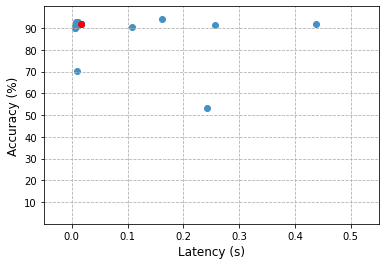

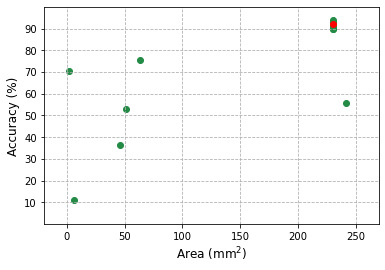

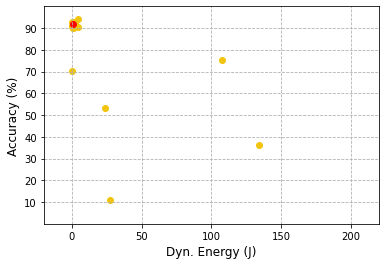

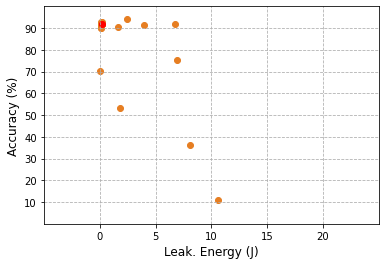

Minimum total energy: 0.07593165093777933


In [4]:
# Plot accuracy vs latency, area, dynamic and leakage energies
%matplotlib inline

colors = {'latency': '#4292C6', 'area': '#238B45', 'dynamic_energy': '#F1C40F', 'leakage_energy': '#E67E22',
         'accuracy': '#916946'}

MAX_LATENCY = 1 # Maximum latency in seconds
MAX_AREA = 1000 # Maximum area in mm^2
MAX_DYNAMIC_ENERGY = 10 # Maximum dynamic energy in Joules
MAX_LEAKAGE_ENERGY = 10 # Maximum leakage energy in Joules

spring_mobilenet_hash = '63bd29899005bdd1f2bce7c1f8f67588408315a9ef5c39b12d000419376b973d'

metric_labels = {'latency': 'Latency', 'area': 'Area', 'dynamic_energy': 'Dyn. Energy', 
                'leakage_energy': 'Leak. Energy', 'accuracy': 'Accuracy'} 
metric_axis_labels = {'latency': 'Latency (s)', 'area': 'Area (mm$^2$)', 'dynamic_energy': 'Dyn. Energy (J)', 
                'leakage_energy': 'Leak. Energy (J)', 'accuracy': 'Accuracy'} 
metric_norm = {'latency': MAX_LATENCY, 'area': MAX_AREA, 'dynamic_energy': MAX_DYNAMIC_ENERGY, 
              'leakage_energy': MAX_LEAKAGE_ENERGY, 'accuracy': 1}

for metric in metric_labels.keys():
    if metric == 'accuracy': continue
    
    fig, ax = plt.subplots()
    simulated_results = [result for result in accel_dataset.values() 
        if result['val_acc'] is not None and result[metric] is not None]
    ax.scatter([result[metric] for result in simulated_results],
               [result['val_acc'] for result in simulated_results], 
               color=colors[metric])
    if metric == 'latency':
        delay_results = [result[metric] for result in simulated_results]
        print(f'Minimum latency: {min([result[metric] for result in simulated_results])}')
    elif metric == 'dynamic_energy':
        dyn_energy_results = [result[metric] for result in simulated_results]
        min_dyn_energy = min([result[metric] for result in simulated_results])
    elif metric == 'leakage_energy':
        leak_energy_results = [result[metric] for result in simulated_results]
        min_leak_energy = min([result[metric] for result in simulated_results])
    ax.scatter([accel_dataset[spring_mobilenet_hash][metric]], 
               [accel_dataset[spring_mobilenet_hash]['val_acc']], color='r')
    ax.set_xlabel(metric_axis_labels[metric], fontsize=12)
    if metric == 'latency':
        ax.set_xlim([-0.05, 0.55])
        ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    if metric == 'area':
        ax.set_xlim([-20, 270])
        ax.set_xticks([0, 50, 100, 150, 200, 250])
    if metric == 'dynamic_energy':
        ax.set_xlim([-20, 220])
        ax.set_xticks([0, 50, 100, 150, 200])
    if metric == 'leakage_energy':
        ax.set_xlim([-5, 25])
        ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_ylim([0, 100])
    ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90])
    plt.grid(linestyle='--')
#     plt.savefig(f'../figures/pareto_frontier_{metric}.pdf', bbox_inches = 'tight')
    plt.show()
    
print(f'Minimum total energy: {min_dyn_energy + min_leak_energy}')

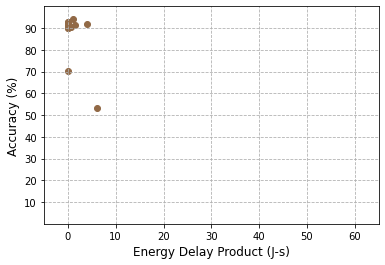

In [12]:
edp_results = [delay_results[i]*(dyn_energy_results[i] + leak_energy_results[i]) for i in range(len(delay_results))]

fig, ax = plt.subplots()
ax.scatter(edp_results, [result['val_acc'] for result in simulated_results], color=colors['accuracy'])
ax.set_xlabel('Energy Delay Product (J-s)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_ylim([0, 100])
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.set_xlim([-5, 65])
plt.grid(linestyle='--')
plt.savefig('../figures/pareto_frontier_edp.pdf', bbox_inches = 'tight')
plt.show()